In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/CPSC536R/Project"
os.chdir(path)
os.listdir(path)

Mounted at /content/gdrive


['sparse-vae-code',
 'scvi-tools',
 'LDVAE_tests',
 'start.ipynb',
 'LDVAE_out',
 'data',
 'LD_pi.ipynb',
 'LDVAE_zeisel_weights.csv',
 'filtered_zs_15_150.csv',
 'LDVAE_zeisel.ipynb']

# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
from scvi.data.fields import AnnDataField
import numpy as np

ModuleNotFoundError: ignored

In [ ]:
# os.kill(os.getpid(), 9)

In [ ]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [ ]:
from scvi.data.fields import AnnDataField
# save_path = "data"
# url = (
#     "https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true"
# )
# adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url=url)

save_path = "data/"
adata = sc.read('data/filtered_zeisel.h5ad')

print(adata)

AnnData object with n_obs × n_vars = 3005 × 5000
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'cell_id', 'level1class', 'level2class'
    var: 'featureType', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'hvg', 'log1p'


In [ ]:
print(adata)

AnnData object with n_obs × n_vars = 3005 × 5000
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'cell_id', 'level1class', 'level2class'
    var: 'featureType', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'hvg', 'log1p'


In [ ]:
import numpy as np

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [ ]:
# setup the anndata for scvi-tools
scvi.model.LinearSCVI.setup_anndata(adata)

/usr/local/lib/python3.9/dist-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [ ]:
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(adata, n_latent=15)

In [ ]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(max_epochs=150, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [00:45<00:00,  3.57it/s, loss=1.51e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [00:45<00:00,  3.30it/s, loss=1.51e+03, v_num=1]


Inspecting the convergence

In [ ]:
train_elbo = model.history["elbo_train"]
test_elbo = model.history["elbo_validation"]

In [ ]:
train_elbo

,elbo_train
epoch,
0,5456.108887
1,3037.829346
2,2685.52832
3,2450.201416
4,2326.542725
...,...
145,1533.426147
146,1534.682007
147,1534.072754


In [ ]:
test_elbo

,elbo_validation
epoch,
9,2077.528564
19,1913.717896
29,2166.430176
39,1713.308716
49,1698.947876
59,1659.287964
69,1623.309326
79,1604.558105
89,1582.673462


<Axes: xlabel='epoch'>

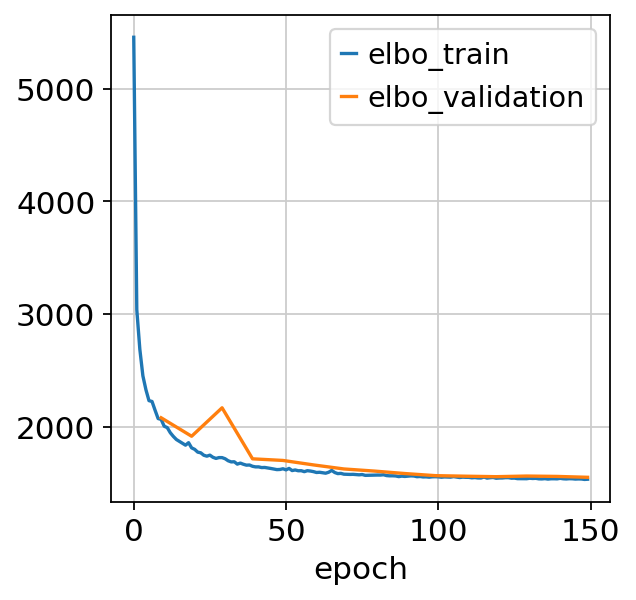

In [ ]:
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [ ]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

<ipython-input-18-49cbe8501dea>:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgd.legendHandles:
<ipython-input-18-49cbe8501dea>:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


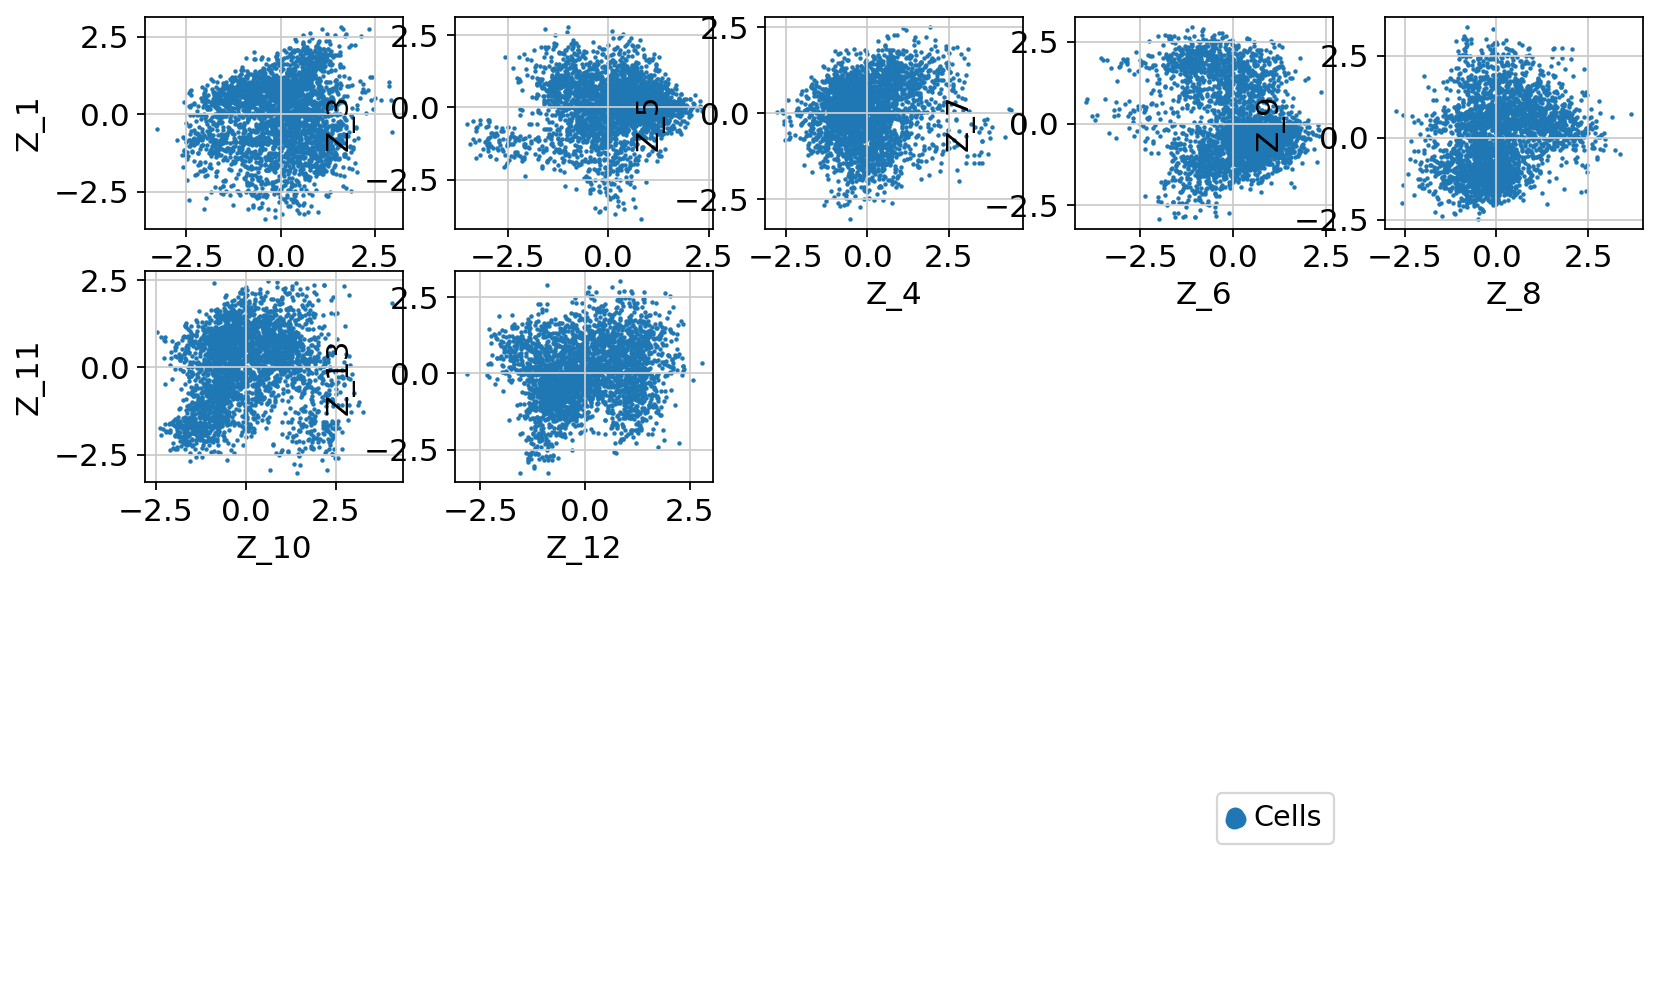

In [ ]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 14, 2):
    plt.subplot(4, 5, int(f / 2) + 1)

    plt.scatter(
        adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(4, 3, 12)
plt.scatter(
    adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

In [ ]:
import numpy as np
import pandas as pd
from importlib import reload
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd

import plotnine as p

In [ ]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [ ]:
z.iloc[:, :-3]

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14
1772071015_C02,-0.409442,0.216325,0.594745,0.915570,-0.457169,0.612724,-1.049147,-2.133353,-0.987684,1.983510,-0.660952,1.491343,-0.669157,-1.012607,0.440325
1772071017_G12,-0.666221,0.601540,0.819183,0.982904,-0.869997,0.409314,-0.840790,-2.423132,-0.952616,1.627398,-0.412199,1.403229,-0.221756,-0.533312,0.502468
1772071017_A05,-0.654258,-0.016809,0.784505,0.973444,-0.206053,0.169755,-0.982241,-1.612943,-0.794189,2.288739,-0.844270,1.631487,-0.532377,-0.531981,0.509278
1772071014_B06,-0.732318,0.269253,1.088515,0.714044,-0.530222,0.476348,-0.906473,-2.318781,-1.047497,1.819544,-0.313334,1.401205,-0.528138,-0.502358,0.682252
1772067065_H06,-0.754985,0.425869,0.737580,1.114612,-0.538495,-0.135076,-0.930143,-2.265391,-1.145961,1.726100,-0.725436,1.488784,-0.419128,-0.762728,0.241624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772067059_B04,-0.989085,-1.502805,0.208093,-2.291116,1.335553,-0.144438,0.239438,-0.345825,0.504148,2.182150,1.934088,-1.392010,1.364282,1.041627,0.923909
1772066097_D04,-0.149954,-0.745006,0.557852,-2.501050,1.236498,1.315962,-0.326949,-0.394596,0.317321,2.018663,1.601631,-1.165818,1.202497,1.732927,-0.233758
1772063068_D01,-0.687093,-1.940301,-0.221245,-1.787280,-0.149963,0.732536,1.277754,-0.462068,0.468886,1.058259,0.455951,-0.218599,2.082537,0.438286,0.683978
1772066098_A12,0.008586,0.137903,-0.193098,-3.599073,0.703686,1.544555,0.972991,-0.084462,1.872107,2.101856,-0.150227,0.324983,0.258786,1.551959,-0.815275


In [ ]:
z = pd.read_csv('filtered_zs_15_150.csv', index_col=0)
# z = z_mean.detach().cpu().numpy()
_, variance_explained = Z_covariance(z.iloc[:, :-3])
idx = np.argsort(variance_explained)[::-1]
# z = pd.DataFrame(z)
# Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')

variance_explained

array([0.13968755, 0.09769419, 0.07683557, 0.07343684, 0.06640882,
       0.04320543, 0.06308643, 0.06203812, 0.04889245, 0.04944484,
       0.05212407, 0.05993131, 0.05385698, 0.05619585, 0.05716154])

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.03479080500883765

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w\_(1, g) * z_1 + ... + w\_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w\_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [ ]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14
Tspan12,0.130140,0.266412,-0.059387,-0.274582,0.035723,0.059615,-0.099182,-0.209435,-0.092223,0.239927,0.049755,-0.240333,-0.292669,0.191860,0.124654
Tshz1,0.267872,-0.017033,-0.180899,0.189992,0.237996,0.244192,-0.220817,-0.135685,-0.090470,0.185160,0.317633,0.323714,0.266233,-0.361654,-0.094435
Adamts15,0.287007,0.303130,0.789794,-0.553637,-0.597914,0.319068,0.084470,-0.349232,-0.308264,0.609589,0.209110,0.189433,0.523690,0.061297,-0.050356
Cldn12,0.166575,0.232206,0.020862,0.117900,-0.093891,0.220894,0.034575,0.040501,-0.038845,-0.159848,-0.102460,0.080114,-0.040985,0.008879,0.054180
Rxfp1,0.520509,0.095651,0.681258,-0.072910,-0.579242,0.015618,0.638765,-0.274251,-0.442916,0.282584,0.081334,0.286154,-0.353086,-0.051499,-0.223653


In [ ]:
loadings.to_csv('LDVAE_zeisel_weights.csv', index=True)

For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [ ]:
print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	Ndst4, -1.0	Egfl6, -0.96	Grpr, -0.9	Grem1, -0.86	Gpr101, -0.86
	...
	Tmem40, 0.92	Plaur, 0.96	Rgs1, 0.97	Cd52, 1.1	Cplx3, 1.1
---------------------------------------------------------------------------------------

Z_1:	Grap, -0.75	Cyba, -0.75	Ctla2b, -0.66	Gimap4, -0.64	Bcl2a1b, -0.61
	...
	Anxa9, 0.67	Fsip1, 0.69	Wnt7a, 0.71	Nts, 0.75	Kl, 0.76
---------------------------------------------------------------------------------------

Z_2:	S100a1, -0.82	Msx2, -0.82	C4b, -0.78	Gm94, -0.77	Irgc1, -0.77
	...
	Crispld1, 0.83	Tacr1, 0.87	Cldn1, 0.88	Oxtr, 0.96	Thbs1, 1.0
---------------------------------------------------------------------------------------

Z_3:	Pln, -1.4	Asb2, -1.2	Tmem119, -1.2	C1s, -1.0	Myh11, -0.97
	...
	Akr1c18, 0.86	Grpr, 0.9	Gna14, 0.92	Tac1, 1.0	Cbln4, 1.1
---------------------------------------------------------------------------------------

Z_4:	C

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [ ]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

In [ ]:
adata

AnnData object with n_obs × n_vars = 3005 × 5000
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'cell_id', 'level1class', 'level2class', '_scvi_batch', '_scvi_labels', 'Z_0', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'leiden_scVI'
    var: 'featureType', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


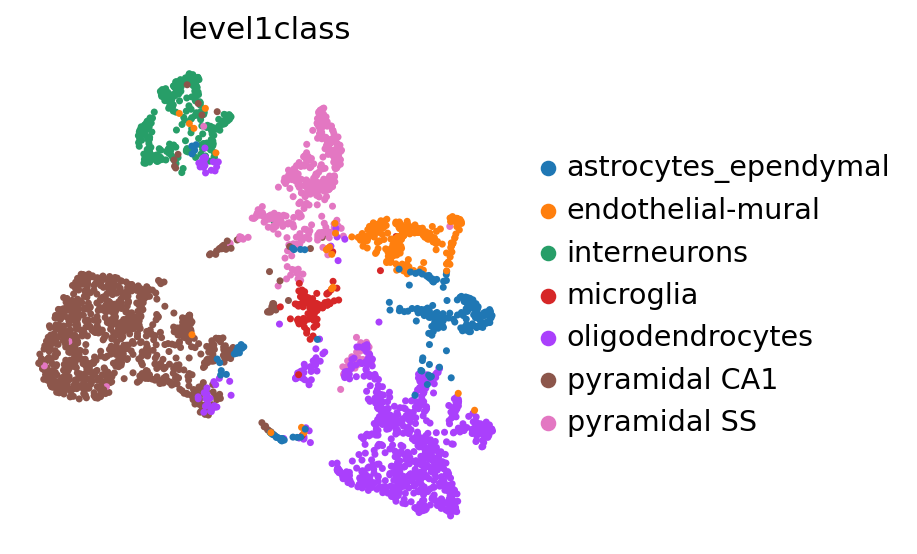

In [ ]:
sc.pl.umap(adata, color=["level1class"])

In [ ]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
adata_subset = adata.obs[zs]
adata_subset

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14,_scvi_batch,_scvi_labels,leiden_scVI
1772071015_C02,-0.409442,0.216325,0.594745,0.915570,-0.457169,0.612724,-1.049147,-2.133353,-0.987684,1.983510,-0.660952,1.491343,-0.669157,-1.012607,0.440325,0,0,5
1772071017_G12,-0.666221,0.601540,0.819183,0.982904,-0.869997,0.409314,-0.840791,-2.423131,-0.952616,1.627398,-0.412199,1.403229,-0.221756,-0.533312,0.502468,0,0,5
1772071017_A05,-0.654258,-0.016809,0.784505,0.973444,-0.206053,0.169755,-0.982241,-1.612943,-0.794189,2.288739,-0.844270,1.631487,-0.532377,-0.531981,0.509278,0,0,5
1772071014_B06,-0.732318,0.269253,1.088515,0.714044,-0.530222,0.476348,-0.906473,-2.318781,-1.047497,1.819544,-0.313334,1.401205,-0.528139,-0.502358,0.682252,0,0,5
1772067065_H06,-0.754985,0.425869,0.737580,1.114612,-0.538495,-0.135076,-0.930143,-2.265391,-1.145961,1.726100,-0.725436,1.488784,-0.419128,-0.762728,0.241624,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772067059_B04,-0.989085,-1.502805,0.208093,-2.291116,1.335553,-0.144438,0.239438,-0.345825,0.504148,2.182150,1.934088,-1.392010,1.364282,1.041627,0.923909,0,0,1
1772066097_D04,-0.149954,-0.745006,0.557852,-2.501050,1.236498,1.315962,-0.326949,-0.394596,0.317321,2.018662,1.601631,-1.165818,1.202497,1.732927,-0.233758,0,0,1
1772063068_D01,-0.687093,-1.940301,-0.221245,-1.787280,-0.149963,0.732536,1.277754,-0.462068,0.468886,1.058259,0.455951,-0.218599,2.082537,0.438286,0.683978,0,0,1
1772066098_A12,0.008586,0.137903,-0.193098,-3.599073,0.703686,1.544555,0.972991,-0.084462,1.872107,2.101856,-0.150227,0.324983,0.258786,1.551959,-0.815274,0,0,1


In [ ]:
# Save the subsetted AnnData object to a CSV file
adata_subset.to_csv('LDVAE_zs_latent.csv')